In [1]:
import time

import neuroglancer
import numpy as np

class InteractiveInference(object):
    def __init__(self, cube):

        viewer = self.viewer = neuroglancer.Viewer()
        viewer.actions.add('move_left', self.move_cube_left)
        viewer.actions.add('move_down', self.move_cube_down)
        viewer.actions.add('move_right', self.move_cube_right)
        viewer.actions.add('move_up', self.move_cube_up)
        viewer.actions.add('morph_volume', self.morph_volume_layer)

        self.cube = cube
        self.off_x = 0
        self.off_y = 0
        self.off_z = 0
        self.grid_layer = GridLayer(self.viewer)
        self.cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000], voxel_offset=[self.off_x, self.off_y, self.off_z])

        with viewer.config_state.txn() as s:
            s.input_event_bindings.data_view['shift+keyw'] = 'move_up'
            s.input_event_bindings.data_view['shift+keys'] = 'move_down'
            s.input_event_bindings.data_view['shift+keya'] = 'move_left'
            s.input_event_bindings.data_view['shift+keyd'] = 'move_right'
            s.input_event_bindings.data_view['shift+keyp'] = 'morph_volume'

        with viewer.txn() as s:
            s.layers['image'] = neuroglancer.ImageLayer(
                source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/MD585_fullres')
            # Resets X/Y/Z plane orientation
            s.navigation.pose.orientation = [0,0,0,1]
            # Zooms out 
        #     s.navigation.zoomFactor = 10000 # If 4panel
            s.navigation.zoomFactor = 5000 # If xy

            # Resets 3D Viewer Orientation
            s.perspectiveOrientation = [0,0,0,1]
            # Zooms out
            s.perspectiveZoom = 75000
            
            s.layers['cube'] = neuroglancer.ImageLayer(source=self.cube_volm)
            s.layers['points'] = self.grid_layer.get_grid_layer()
            # s.layers['points'] = neuroglancer.AnnotationLayer(voxel_size=[100000, 100000, 100000])

    def move_cube_left(self, action_state):

        self.off_x -= 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_right(self, action_state):
        self.off_x += 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_up(self, action_state):
        self.off_y -= 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer

    def move_cube_down(self, action_state):
        self.off_y += 10
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer
            
    def morph_volume_layer(self, action_state):
        self.grid_layer.update_grid_dict()
        grid_map = self.grid_layer.grid_dict # Gets grid_dict
    
        self.cube = update_volume( grid_map, self.cube )
        cube_volm = neuroglancer.LocalVolume(data=self.cube, voxel_size=[10000, 10000, 10000],
                                             voxel_offset=[self.off_x, self.off_y, self.off_z])
        cube_layer = neuroglancer.SegmentationLayer(source=cube_volm)
        with self.viewer.txn() as s:
            s.layers['cube'] = cube_layer
            
            
class GridLayer():
    def __init__(self, viewer, shape=(80, 60, 50),  vox_size=(100000, 100000, 100000)):
        self.vox_size = vox_size
        self.shape = shape
        self.jump_x = 15
        self.jump_y = 15
        self.jump_z = 20
        self.viewer = viewer
        self.grid_dict = {}
        self.triangle_index_to_grid_pts = {}

    def get_grid_layer(self):
        grid_layer = neuroglancer.AnnotationLayer(voxel_size=self.vox_size)
        # grid_array = np.empty(self.shape, dtype=object)

        point_list = []

        for i in range(0, self.shape[0], self.jump_x):
            for j in range(0, self.shape[1], self.jump_y):
                for k in range(0, self.shape[2], self.jump_z):
                    self.grid_dict[repr((i, j, k))] = (i, j, k)
                    point_list.append((i, j, k))

        grid_layer.annotations = [neuroglancer.PointAnnotation(id=repr(pos), point=pos) for pos in point_list]

        return grid_layer
    
    def update_grid_dict(self):
        """
        Loads the current locations of every gridpoint and saves in the grid_dict format
        """
        with self.viewer.txn() as s:
            ss = s.layers['points']
            grid_as_json = ss.to_json()
            grid_list = grid_as_json['annotations']

        for gridpnt in grid_list:
            original_pos = gridpnt['id']
            curr_pos = gridpnt['point']
            self.grid_dict[original_pos] = tuple(curr_pos)

    def print_coordiante(self):
        if 'selectedAnnotation' in self.viewer.state.layers._layers[2]._json_data:
            print(self.grid_dict[self.viewer.state.layers._layers[2]._json_data['selectedAnnotation']])
            

def update_volume( grid_map, volume ):
    volume_shape = np.shape( volume )
    
    if grid_map['(0, 0, 0)'] == (0,0,0):
        if volume[0,0,0] == 0:
            new_volume = np.ones( volume_shape, dtype=np.uint8 )
        elif volume[0,0,0] != 0:
            new_volume = np.zeros( volume_shape, dtype=np.uint8 )
        return new_volume
    else:
        return volume
    
    

In [2]:
def get_cube_test_volume():
    cube = np.zeros((100, 100, 100), dtype=np.uint8)

    cube[:, :, :10] = 1
    cube[:, :, 90:100] = 1

    cube[:10, :, :] = 1
    cube[90:100, :, :] = 1

    cube[:, :10, :] = 1
    cube[:, 90:100, :] = 1
    
    return cube

cube = get_cube_test_volume()

neuroglancer.set_server_bind_address(bind_address='0.0.0.0', bind_port=35000)

inf = InteractiveInference(cube)
viewer = inf.viewer
ip_name = 'ec2-52-53-248-156.us-west-1.compute.amazonaws.com'  ## Change for different machine
ip_name = '132.239.73.85'  ## Change for different machine

print('http://' + ip_name + ':' + viewer.get_viewer_url().split(':')[2])

http://132.239.73.85:35000/v/fe170061c575d10428f33570dd9b1dae81734e90/


In [76]:
inf.grid_layer.grid_dict

{'(0, 0, 0)': [13.00509262084961, 5.022656440734863, -1.770879087814592e-08],
 '(0, 0, 20)': [0, 0, 20],
 '(0, 0, 40)': [0, 0, 40],
 '(0, 50, 0)': [0, 50, 0],
 '(0, 50, 20)': [0, 50, 20],
 '(0, 50, 40)': [0, 50, 40],
 '(50, 0, 0)': [50, 0, 0],
 '(50, 0, 20)': [50, 0, 20],
 '(50, 0, 40)': [50, 0, 40],
 '(50, 50, 0)': [50, 50, 0],
 '(50, 50, 20)': [50, 50, 20],
 '(50, 50, 40)': [50, 50, 40]}

In [43]:
inf.grid_layer.grid_dict

{'(0, 0, 0)': (16.3847713470459, 6.646653175354004, -7.223887266150086e-09),
 '(0, 0, 20)': (0, 0, 20),
 '(0, 0, 40)': (0, 0, 40),
 '(0, 50, 0)': (0, 50, 0),
 '(0, 50, 20)': (0, 50, 20),
 '(0, 50, 40)': (0, 50, 40),
 '(50, 0, 0)': (50, 0, 0),
 '(50, 0, 20)': (50, 0, 20),
 '(50, 0, 40)': (50, 0, 40),
 '(50, 50, 0)': (50, 50, 0),
 '(50, 50, 20)': (50, 50, 20),
 '(50, 50, 40)': (50, 50, 40)}

In [6]:
grid_dict = {}
with inf.viewer.txn() as s:
    ss = s.layers['points']
    grid_as_json = ss.to_json()
    grid_list = grid_as_json['annotations']
    
for gridpnt in grid_list:
    original_pos = gridpnt['id']
    curr_pos = gridpnt['point']
    grid_dict[original_pos] = curr_pos

In [9]:
type((1,2))

tuple

In [10]:
tuple(curr_pos)

(50, 50, 40)

In [61]:
dir(ss)

['__class__',
 '__deepcopy__',
 '__delattr__',
 '__doc__',
 '__format__',
 '__getattr__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_cached_wrappers',
 '_get_wrapped',
 '_json_data',
 '_lock',
 '_readonly',
 '_set_wrapped',
 'layer',
 'name',
 'supports_readonly',
 'to_json',
 'visible']

# Grid Transform

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def convert_coor_xy_list_to_x_y_list( coordinates ):
    x_coors = []
    y_coors = []
    for coor in coordinates:
        y, x = coor
        x_coors.append( int(x) )
        y_coors.append( int(y) )
    return [x_coors, y_coors]

In [5]:
test_matrix = np.zeros((10,10))
for i in range(10):
    test_matrix[i,i]=1
    
test_grid = [[0,0],[4,0],[9,0],[0,4],[4,4],[9,4],[0,9],[4,9],[9,9]]

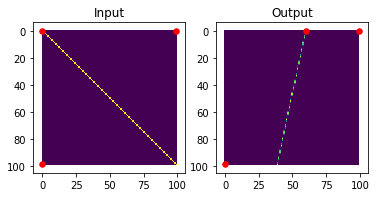

In [160]:
test_matrix = np.zeros((100,100))
for i in range(100):
    test_matrix[i,i]=1
    
test_grid = [[0,0],[4,0],[9,0],[0,4],[4,4],[9,4],[0,9],[4,9],[9,9]]

img = test_matrix
rows,cols = img.shape

pts1 = np.float32([[0,0],[99,0],[0,99]]) # [x,y]
pts2 = np.float32([[60,0],[99,0],[0,99]]) # [x,y]

M = cv2.getAffineTransform(pts1,pts2)

dst = cv2.warpAffine(img,M,(cols,rows))

y_coors_1, x_coors_1 = convert_coor_xy_list_to_x_y_list( pts1 )
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(121),plt.scatter(x_coors_1,y_coors_1, c='r', s=30)
y_coors_2, x_coors_2 = convert_coor_xy_list_to_x_y_list( pts2 )
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.subplot(122),plt.scatter(x_coors_2,y_coors_2, c='r', s=30)
plt.show()

In [163]:
grid_dict = {'(0, 0)': (0,0), '(0, 50)': (0,50), '(0, 100)': (0,100),
             '(50, 0)': (50,0), '(50, 50)': (60,50), '(50, 100)': (50,100),
             '(100, 0)': (100,0), '(100, 50)': (100,50), '(100, 100)': (100,100)}
jump_x = 50
jump_y = 50

def get_triangle_indices_to_vertices( grid_dict, triangle_type='sawtooth' ):
    """
    Sawtooth: Every point with two unique, adjacent points will create a triangle.
    """
    
    original_grid_coors = []
    
    for original_grid_pnt_str in grid_dict.keys():
        # Convert the string-key into coordinate pair
        original_grid_pnt_coors = original_grid_pnt_str.replace('(','').replace(')','').replace(' ','').split(',')
        original_grid_pnt_coors = [int(original_grid_pnt_coors[0]), int(original_grid_pnt_coors[1])]
        # Add the grid point coordinates to the list of original grid point coordinates
        original_grid_coors.append( original_grid_pnt_coors )
        
    triangle_indices_to_vertices = {}
    triangle_index = 0
    
    if triangle_type=='sawtooth':
        for pnt in original_grid_coors:
            right_gridpnt = list( np.add( pnt, [jump_x,0] ) )
            down_gridpnt = list( np.add( pnt, [0,jump_y] ) )
            
            up_right_gridpnt = list( np.add( pnt, [jump_x,-jump_y] ) )
            
            # Check for RIGHT point and DOWN point
            if (right_gridpnt in original_grid_coors) and (up_right_gridpnt in original_grid_coors):
                triangle_indices_to_vertices[triangle_index] = [pnt, right_gridpnt, up_right_gridpnt]
                triangle_index += 1

            # Check for RIGHT point and RIGHT+UP point
            if (right_gridpnt in original_grid_coors) and (down_gridpnt in original_grid_coors):
                triangle_indices_to_vertices[triangle_index] = [pnt, right_gridpnt, down_gridpnt]
                triangle_index += 1
                
    return triangle_indices_to_vertices

get_triangle_indices_to_vertices( grid_dict, triangle_type='sawtooth' )

{0: [[50, 100], [100, 100], [100, 50]],
 1: [[0, 0], [50, 0], [0, 50]],
 2: [[50, 50], [100, 50], [100, 0]],
 3: [[50, 50], [100, 50], [50, 100]],
 4: [[0, 100], [50, 100], [50, 50]],
 5: [[0, 50], [50, 50], [50, 0]],
 6: [[0, 50], [50, 50], [0, 100]],
 7: [[50, 0], [100, 0], [50, 50]]}

[[50, 50], [100, 50], [100, 0]]
[[60, 50], [100, 50], [100, 0]]


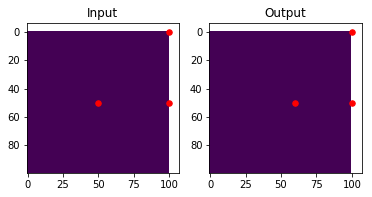

[[50, 50], [100, 50], [50, 100]]
[[60, 50], [100, 50], [50, 100]]


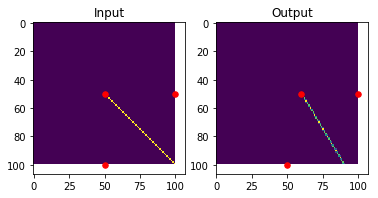

[[0, 100], [50, 100], [50, 50]]
[[0, 100], [50, 100], [60, 50]]


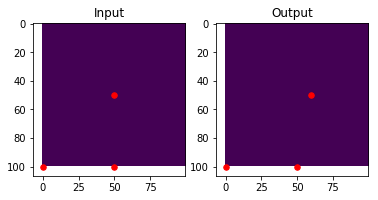

[[0, 50], [50, 50], [50, 0]]
[[0, 50], [60, 50], [50, 0]]


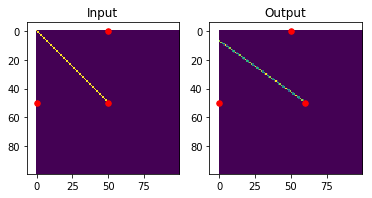

[[0, 50], [50, 50], [0, 100]]
[[0, 50], [60, 50], [0, 100]]


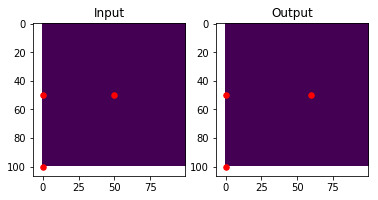

[[50, 0], [100, 0], [50, 50]]
[[50, 0], [100, 0], [60, 50]]


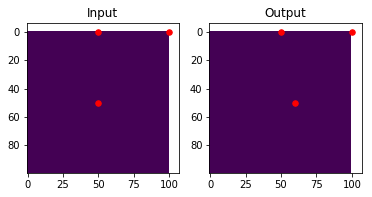

In [178]:
triangle_indices_to_vertices = get_triangle_indices_to_vertices( grid_dict, triangle_type='sawtooth' )

for grid1_triangle_vertices in triangle_indices_to_vertices.values():
    triangle_is_distorted = False
    # Check every vertex in the triangle, if any have been changed, then set
    # `triangle_is_distorted` to True
    for coordinate_pair in grid1_triangle_vertices:
        grid1_coordinate_pair_string = str(tuple( coordinate_pair ))
        grid2_coordinate_pair_string = str(grid_dict[grid1_coordinate_pair_string])
        if grid2_coordinate_pair_string != grid1_coordinate_pair_string:
            triangle_is_distorted = True
            break
    # If none of the 3 vertices have been changed, then continue to the next triangle
    if not triangle_is_distorted:
        continue
    
    # If the triangle *HAS BEEN DISTORTED*
    large_num = 999999999 # an arbitrarily large number guaranteed to be overwritten by smaller numbers
    grid1_min_max_x_y = [large_num,-1,large_num,-1] # minX, maxX, minY, maxY
    grid2_min_max_x_y = [large_num,-1,large_num,-1] # minX, maxX, minY, maxY
    # The for loop finds the grid2 vertices and put into this list
    grid2_triangle_vertices = []
    for grid1_coordinate_pair in grid1_triangle_vertices:
        # Update the cropping box for the grid1 points (using min/max x/y values)
        grid1_min_max_x_y[0] = min( grid1_min_max_x_y[0], grid1_coordinate_pair[0] )
        grid1_min_max_x_y[1] = max( grid1_min_max_x_y[1], grid1_coordinate_pair[0] )
        grid1_min_max_x_y[2] = min( grid1_min_max_x_y[2], grid1_coordinate_pair[1] )
        grid1_min_max_x_y[3] = max( grid1_min_max_x_y[3], grid1_coordinate_pair[1] )
        
        # Add mapped (grid1->grid2) coordinates to the grid2 vertices list
        grid1_coordinate_pair_string = str(tuple( grid1_coordinate_pair ))
        grid2_triangle_vertices.append( list(grid_dict[grid1_coordinate_pair_string]) )
        
        grid2_coordinate_pair = list(grid_dict[grid1_coordinate_pair_string])
        # Update the cropping box for the grid2 points (using min/max x/y values)
        grid2_min_max_x_y[0] = min( grid2_min_max_x_y[0], grid2_coordinate_pair[0] )
        grid2_min_max_x_y[1] = max( grid2_min_max_x_y[1], grid2_coordinate_pair[0] )
        grid2_min_max_x_y[2] = min( grid2_min_max_x_y[2], grid2_coordinate_pair[1] )
        grid2_min_max_x_y[3] = max( grid2_min_max_x_y[3], grid2_coordinate_pair[1] )
       
    print(grid1_triangle_vertices)
    print(grid2_triangle_vertices)
    # The affine transformation is computed using the vertices, which are relabeled as "mapping points"
    mapping_pts1 = np.float32(grid1_triangle_vertices)
    mapping_pts2 = np.float32(grid2_triangle_vertices)
    
    # Apply the affine transformation to the cropped img
    M = cv2.getAffineTransform(mapping_pts1,mapping_pts2)
    rows,cols = img.shape
    cropped_img = np.zeros( (rows,cols) )
    cropped_img[ grid1_min_max_x_y[2]:grid1_min_max_x_y[3], \
                 grid1_min_max_x_y[0]:grid1_min_max_x_y[1] ] = \
           img[ grid1_min_max_x_y[2]:grid1_min_max_x_y[3], \
                grid1_min_max_x_y[0]:grid1_min_max_x_y[1] ]
    warped_img = cv2.warpAffine(cropped_img,M,(cols,rows))

    y_coors_1, x_coors_1 = convert_coor_xy_list_to_x_y_list( mapping_pts1 )
    plt.subplot(121),plt.imshow(cropped_img),plt.title('Input')
    plt.subplot(121),plt.scatter(x_coors_1,y_coors_1, c='r', s=30)
    y_coors_2, x_coors_2 = convert_coor_xy_list_to_x_y_list( mapping_pts2 )
    plt.subplot(122),plt.imshow(warped_img),plt.title('Output')
    plt.subplot(122),plt.scatter(x_coors_2,y_coors_2, c='r', s=30)
    plt.show()

In [146]:
grid_dict.values()

[(50, 100),
 (100, 100),
 (100, 50),
 (0, 0),
 (100, 0),
 (75, 75),
 (0, 100),
 (0, 50),
 (50, 0)]

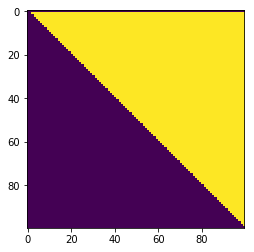

In [51]:
from matplotlib.path import Path

tupVerts = [(0,0),(100,100), (100,0)]

x, y = np.meshgrid(np.arange(100), np.arange(100)) # make a canvas with coordinates
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T 

p = Path(tupVerts) # make a polygon
grid = p.contains_points(points)
mask = grid.reshape(100,100) # now you have a mask with points inside a polygon
plt.imshow(mask)

In [180]:
def get_mask_from_vertices( tupVerts ):
    
    from matplotlib.path import Path

#     tupVerts = [[0,0],[100,100], [100,0]]

    x, y = np.meshgrid(np.arange(100), np.arange(100)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(tupVerts) # make a polygon
    grid = p.contains_points(points)
    mask = grid.reshape(100,100) # now you have a mask with points inside a polygon
    plt.imshow(mask)

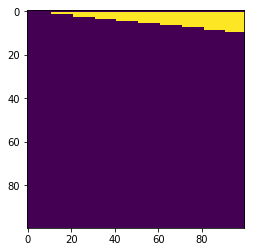

In [181]:
get_mask_from_vertices( [[0,0],[1000,100], [100,0]] )